In [76]:
# Import modules (tf_env)
import cv2
import numpy as np
import csv
from matplotlib import pyplot as plt
import pytesseract
import os
from scipy.spatial import ConvexHull

<function matplotlib.pyplot.show(close=None, block=None)>

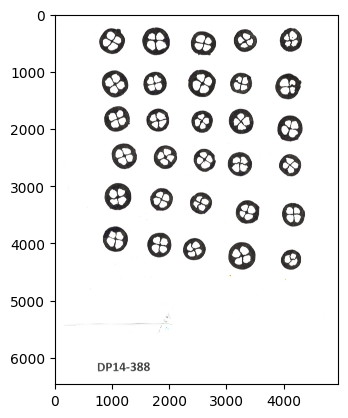

In [118]:
# Read image
img_path = "/Users/alejandra/Documents/GitHub/CranberryLab/Internal_Structure/PDF/Stamp_photos/JPG/lal01.jpg"
img = cv2.imread(img_path)

plt.imshow(img)
plt.show

In [119]:
# Detect the text in the image 
def extract_sample_id(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray_image, lang='eng') # English + Spanish
    filtered_text = text.strip().split("\n")[0]
    return filtered_text

sample_id = extract_sample_id(img)

# If the text is not detected, file name will be our sample id:
if sample_id is None:
    file_name = os.path.basename(img_path)
    sample_id = file_name 

print(sample_id) 

DP14-388


In [63]:
# Scaling pixeles to cm
# Width and height of the scan (letter size by default)
img_width_cm = 21.8
img_height_cm = 27.85

if img is not None:
    img_height_px, img_width_px = img.shape[:2]
    px_per_cm_x = img_width_px / img_width_cm
    px_per_cm_y = img_height_px / img_height_cm
else:
    raise ValueError('Image loadind error: unable to proceed with scale calculation')

<function matplotlib.pyplot.show(close=None, block=None)>

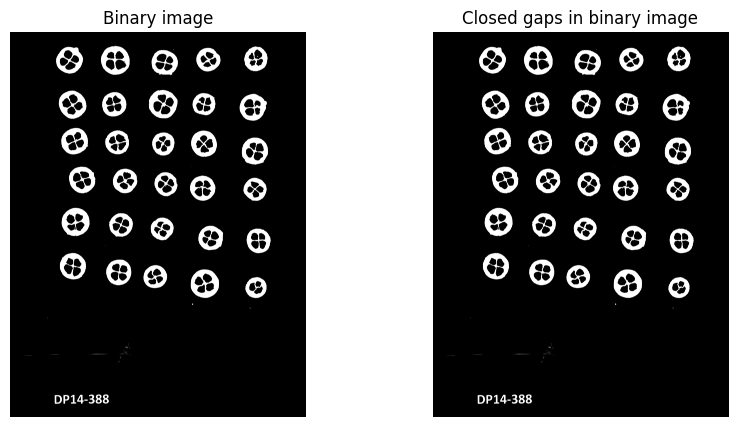

In [64]:
# Detecting fruits and locules using hierarchical segmentation with cv2
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert the image from BGR to grayscale to simplify the process, removing color information and reducing the data to a single channel.
# Create a binary mask using the gray image 
# Pixels with intensity > 150 are transformed into black (0). The remaining pixels will be converted to white (255).
_, binary = cv2.threshold(gray_img, 150, 255, cv2.THRESH_BINARY_INV) 

# Smoothing irregular edges and closing small gaps in circular objects (fruits).
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
closed_binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel) # New image with closed gaps

# Find contours in the closed_binary image
contours, hierarchy = cv2.findContours(closed_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1) # 1 row, 2 columns, position 1
plt.imshow(binary, cmap='gray')
plt.title('Binary image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(closed_binary, cmap='gray')
plt.title('Closed gaps in binary image')
plt.axis('off')

plt.show

In [101]:
## Filter our contours that are either too small or not circular enough (not fruits)
# c: single contour
# min_area: minimum area to be consider a valid contour
# min_circularity and max_circularity: Thresholds for circularity. 

def is_contour_bad(c, min_area=500, min_circularity=0.7, max_circularity=1):
    area = cv2.contourArea(c) # Get contour area
    perimeter = cv2.arcLength(c, True) # Get contour perimeter; True indicates that the contour is closed
    if perimeter == 0:
        return True # If the perimeter is 0, the contour is not valid
    circularity = 4 * np.pi * (area / (perimeter * perimeter)) # Propossed by Cox (1927)
    return area < min_area or not (min_circularity <= circularity <= max_circularity)

## Filtering external contours (fruits) and internal contours (locules).
# min_loculs_area =  Minimun area to be consider a valid locule

min_locus_area = 50 

filtered_fruit_locus_map = {} # Create an empty dictonary to save our results

for i in range(len(contours)):
    if hierarchy[0][i][3] == -1 and not is_contour_bad(contours[i]): # keep valid external circular contours (hierarchy == -1)
        valid_locules = [
            j for j in range(len(contours))
            if hierarchy[0][j][3] == i and cv2.contourArea(contours[j]) > min_locus_area # For each contour j, check if they are internal contours i (locules; hierarchy == i)
        ]
        if len(valid_locules) > 1:
            filtered_fruit_locus_map[i] = valid_locules # Save external contours that have more than 1 valid locule


print(f'Number of fruits detected: {len(filtered_fruit_locus_map)}')

Number of fruits detected: 30


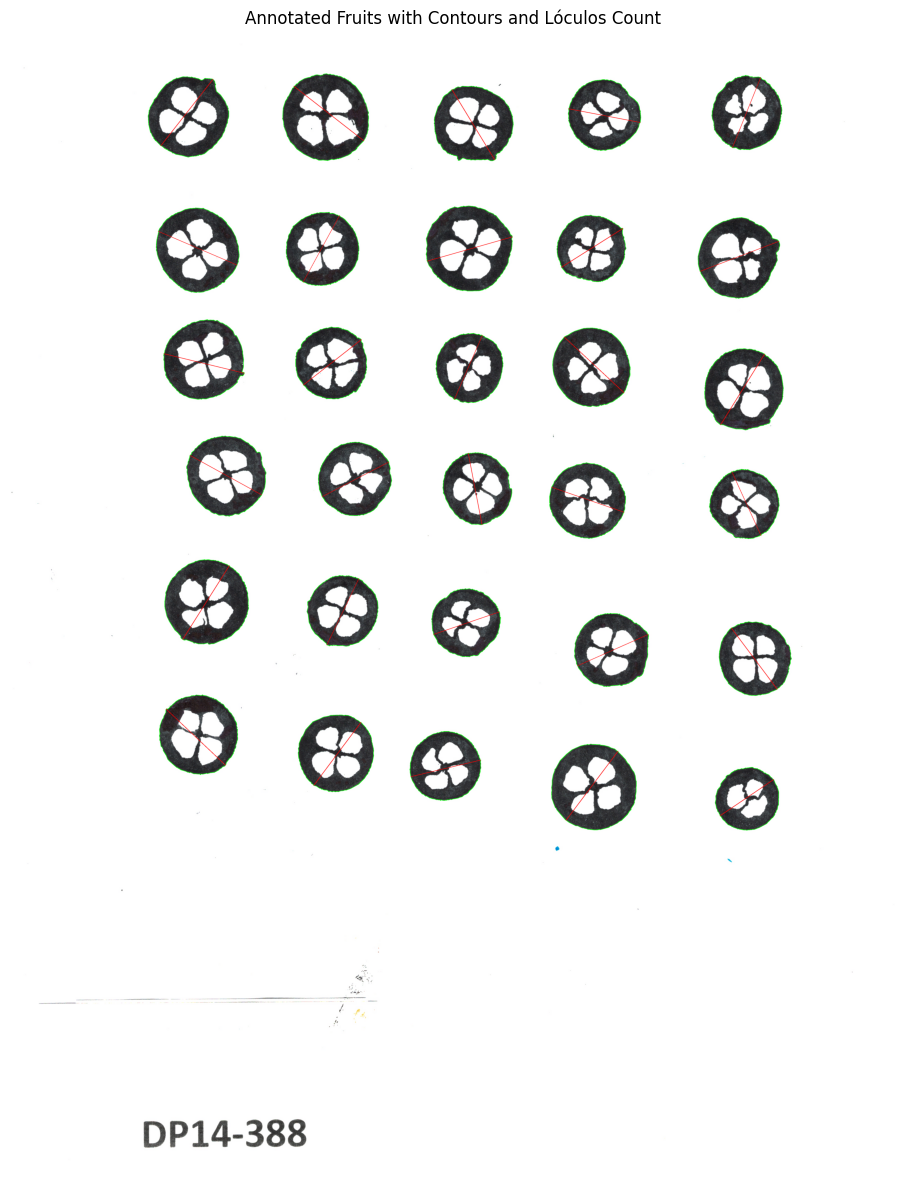

In [ ]:
# Calculate fruit and locule metrics
results = [] # Create an empty list to save results
image_with_annotations = img.copy() # Create a copy of our image to annotate results
sequential_id = 1  # Secuencial IDs

for fruit_id, locules in filtered_fruit_locus_map.items(): 
    n_locules = len(locules) # Count the number of locules per fruit_id 
    
    epsilon = 0.001 * cv2.arcLength(contours[fruit_id], True)
    smoothed_contour = cv2.approxPolyDP(contours[fruit_id], epsilon, True)
    points = smoothed_contour.reshape(-1, 2)

    ## Calculate the major axis length 
    points = contours[fruit_id].reshape(-1,2) # Get the coordinates (x,y) of each fruit 
    hull = ConvexHull(points) # Calculate the convex hull of the points x and y
    max_diameter_px = 0
    point1 = None # Initiate the variables to save the coordinates of the major axis length
    point2 = None
    
    # Find the two points with the major diameter
    for i in hull.vertices:
        for j in hull.vertices:
            dist = np.linalg.norm(points[i] - points[j])
            if dist > max_diameter_px:
                max_diameter_px = dist
                point1 = points[i]
                point2 = points[j]
                
    # Dibujar el contorno suavizado y el diámetro mayor en la imagen
    cv2.drawContours(image_with_annotations, [smoothed_contour], -1, (0, 255, 0), 2)  # Contorno en verde
    if point1 is not None and point2 is not None:
        cv2.line(
            image_with_annotations,
            tuple(point1.astype(int)),
            tuple(point2.astype(int)),
            (0, 0, 255), 2  # Línea roja para el diámetro mayor
    )
    
    results.append({
        "Sample_ID": sample_id,
        'n_locules': n_locules
    })
    
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(image_with_annotations, cv2.COLOR_BGR2RGB))
plt.title("Annotated Fruits with Contours and Lóculos Count")
plt.axis('off')
plt.show()
